In [1]:
# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt

# To supress the deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
%run utility_functions.ipynb 

In [2]:
from qiskit_ionq import IonQProvider
provider = IonQProvider('MSZ3nHSUkWvLg4YucxMDpNDESpGqQx3i')
print(provider.backends()) 

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [3]:
def cloningcircuit(alice_bit = 0, alice_base = 0, theta1=np.pi/8):    
    
    qr = QuantumRegister(3,'q')
    cr = ClassicalRegister(3,'c')

    qc = QuantumCircuit(qr,cr)
    
    if alice_bit == 0:
        if alice_base == 0:
            pass
        else:
            qc.h(qr[0])
    elif alice_bit == 1:
        if alice_base == 0:
            qc.x(qr[0])
        else:
            qc.x(qr[0])
            qc.h(qr[0])

                
    qc.barrier()

    # theta1=theta3=np.pi/4
    # theta2 = -math.asin(0.5 - math.sqrt(2)/3) ** 0.5
#     theta2 = 0.5 * (np.arccos((np.cos(2*theta1))/(np.sin(2*theta1))))
    
    if theta1 <= np.pi/4:
        theta2 = 0.5 * np.arccos(np.cos(2*theta1)/np.sin(2*theta1))
    if theta1 > np.pi/4:
        theta2 = 0.5 * np.arccos(-np.cos(2*theta1)/np.sin(2*theta1))
        
    theta3 = np.arctan(np.tan(theta1) * np.tan(theta2))
    
#     print(theta1,theta2,theta3)
    
    #qc.sdg(y basis)
    
#     qc.u(2*theta1,0,0,qr[1])
    qc.ry(2*theta1,qr[1])
    qc.cx(qr[1],qr[2])
#     qc.u(2*theta2,0,0,qr[2])
    qc.ry(2*theta2,qr[2])
    qc.cx(qr[2],qr[1])
#     qc.u(2*theta3,0,0,qr[1])
    qc.ry(2*theta3,qr[1])
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])
    qc.cx(qr[1],qr[0])
    qc.cx(qr[2],qr[0])

    qc.barrier()
    
    if alice_base == 0:
        pass
    else:
        qc.h(qr[0])
        qc.h(qr[1])

    
    sim = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=sim)
    result = job.result()
    sv = result.get_statevector()
    
    qc.measure([0,1],[0,1])
    
#     display(qc.draw(output='mpl'))
    return qc,sv

def displayresult(qc,sv,alice_bit=0,show=True,useIonQ=False):
    if not useIonQ:
        # define the backend
        backend= Aer.get_backend('qasm_simulator')
        # run the simulation
        job = execute(qc, backend=backend, shots = 1024)
        #get the result
        counts = job.result().get_counts()

    else:
        
        ionq = provider.get_backend("ionq_simulator")
        job = ionq.run(qc, backend=ionq, shots = 1024)
        counts = job.result().get_counts()
    
#     if show:
    print ("Counts:",counts)

    prob_bob = 0
    prob_alice = 0
    for key in counts.keys():
        if int(list(key)[-1]) == alice_bit:
            prob_bob += counts[key]/1024
        if int(list(key)[-2]) == alice_bit:
            prob_alice += counts[key]/1024
    
    print("The probability of Bob measuring the correct bit is ", prob_bob, "and the probability of Alice eavesdropping the correct bit is", prob_alice)
    if show:
#         print("The probability of Bob measuring the correct bit is ", prob_bob, "and the probability of Alice eavesdropping the correct bit is", prob_alice)
        # plot the histogram of the results
        display(plot_histogram(counts))
        display(plot_bloch_multivector(sv))
        display(array_to_latex(sv))
    
    return prob_bob, prob_alice, counts

In [5]:
theta1s = np.linspace(1.1,2.9,19)
print(theta1s)
theta1s = np.pi/8 * theta1s 

[1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8
 2.9]


/opt/miniconda3/lib/python3.9/site-packages/qiskit_ionq/ionq_backend.py:314: UserWarning: Option backend is not used by this backend
  return super().run(circuit, **kwargs)


Counts: {'000': 10, '001': 166, '010': 236, '011': 612}
The probability of Bob measuring the correct bit is  0.759765625 and the probability of Alice eavesdropping the correct bit is 0.828125
Counts: {'000': 3, '001': 205, '010': 147, '011': 669}
The probability of Bob measuring the correct bit is  0.853515625 and the probability of Alice eavesdropping the correct bit is 0.796875
Counts: {'000': 0, '001': 255, '010': 114, '011': 655}
The probability of Bob measuring the correct bit is  0.888671875 and the probability of Alice eavesdropping the correct bit is 0.7509765625
Counts: {'000': 1, '001': 314, '010': 67, '011': 642}
The probability of Bob measuring the correct bit is  0.93359375 and the probability of Alice eavesdropping the correct bit is 0.6923828125
Counts: {'000': 5, '001': 305, '010': 50, '011': 664}
The probability of Bob measuring the correct bit is  0.9462890625 and the probability of Alice eavesdropping the correct bit is 0.697265625
Counts: {'000': 4, '001': 359, '010

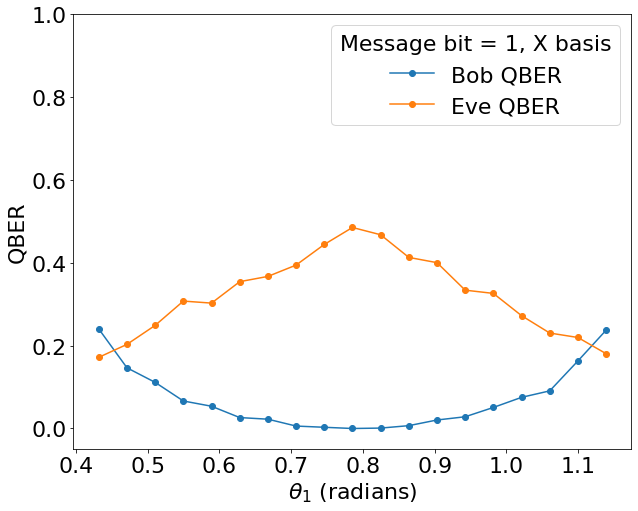

In [7]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

counts_list = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 1, alice_base = 1, theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice,counts = displayresult(qc,sv,alice_bit=1,show=False,useIonQ=True)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)
    
    counts_list.append(counts)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 1, X basis")
plt.show()

In [8]:
probbob_theory = []
probalice_theory = []
errbob_theory = []
erralice_theory = []

for val in theta1s:
    probbob_theory.append(0.5 * (1 + np.sin(2 * val)))
    probalice_theory.append(0.5 * (1 + np.abs(np.cos(2 * val))))
    errbob_theory.append(1 - (0.5 * (1 + np.sin(2 * val))))
    erralice_theory.append(1 - (0.5 * (1 + np.abs(np.cos(2 * val)))))
    

In [9]:
def getjobresult(id = "",alice_bit=0):
    ionq = provider.get_backend("ionq_qpu")
    retrieved = ionq.retrieve_job(id) 
    counts = retrieved.result().get_counts()
#     print(counts)
#     plot_histogram(counts)

    prob_bob = 0
    prob_alice = 0
    for key in counts.keys():
        if int(list(key)[-1]) == alice_bit:
            prob_bob += counts[key]/1024
        if int(list(key)[-2]) == alice_bit:
            prob_alice += counts[key]/1024

        err_bob = 1 - prob_bob
        err_alice = 1 - prob_alice
            
    return prob_bob, prob_alice, err_bob, err_alice, counts

In [13]:
job_ids_new = ['986f02b3-a9c0-44e7-9c8b-5711cc8273b0',
 '44eeeeaa-c3b5-4e5b-ad5d-c4bd91d8869a',
 '268320f7-0d79-4346-86a9-cb359e81c47b',
 '7c55170a-9764-4807-aab7-313c1bf01f9c',
 '3077eadf-87be-467a-a3f4-bf76aef8bf17',
 '5f86c734-91fc-48e3-ab49-dbacec03a347',
 'c06c80e5-637f-43fa-a696-a3438ba82f2c',
 'c67bab7d-0f0c-4a66-9c5d-54a9d3452de3',
 'e853293a-9a8e-4f3c-b070-aa32f3e1d05b',
 '77951986-b2ea-43e2-bbf2-b68e564008e7',
 'fc70f179-6c04-4cbe-ab98-5fa391af3b6e',
 '19316f66-f278-45d5-8917-d92f8e160abe',
 '32e69ce1-cf6f-4ee7-bd0d-1e3cdf439d94',
 '12bb3330-3e47-44cd-816f-50fc17a411ab',
 'c21d636b-e281-437d-8b3a-bb99ea8740dc',
 'a4e5ddc9-f3e1-4c11-9111-7013d156725e',
 'b143446a-55d9-4d49-9a52-c0c15b203817',
 '26352442-c8e5-42aa-8277-498faf9a3b68',
 'ef4e2a57-7749-4965-9c15-20a3db70cdfb']

job_ids = ['ce104ab1-c708-4306-af23-28baebe1c7b2',
 'a3dd3a6c-37d1-4cac-95c4-7c680d64fff7',
 'e8d97f69-32ed-47fe-b428-9bea34586b58',
 '47f9c7ba-7ef5-43c3-b52d-389056dd5a6e',
 'df10cf29-b913-469e-bde6-9ae7e86a76ce',
 '4cae54cb-7c31-427e-9b99-4e3f5ca13be6',
 'e6f10778-4653-4d6c-8220-66eb6ed009db',
 '883ffcd8-4761-475d-9e38-fb348e0331f0',
 '3e89d062-5fc5-4b5b-b3e8-7d624b4e068e',
 '1b7959c8-da81-47c5-887c-9842f5652256',
 '922b4a71-f0bb-41f6-b13b-85f490387feb',
 '81fea940-510a-4a68-875a-56f41dc55869',
 '455ee888-6529-427f-a023-a50be89ef376',
 '949e24f6-9758-4679-9f9a-d663f05d3bf8',
 '6da03d59-ed76-4d0d-b5fa-5f3fb5a60ba3',
 'ae51721c-beb4-40a6-99e8-bde300defead',
 'e669a769-8d9d-4448-b8e0-c91b50e55f2a',
 '32d9b7ce-139f-4b91-ad73-439c35ec0c85',
 '88eb2d86-ce39-42d0-ab5b-9c0b19b81689']

job_ids_new

job_ids

['ce104ab1-c708-4306-af23-28baebe1c7b2',
 'a3dd3a6c-37d1-4cac-95c4-7c680d64fff7',
 'e8d97f69-32ed-47fe-b428-9bea34586b58',
 '47f9c7ba-7ef5-43c3-b52d-389056dd5a6e',
 'df10cf29-b913-469e-bde6-9ae7e86a76ce',
 '4cae54cb-7c31-427e-9b99-4e3f5ca13be6',
 'e6f10778-4653-4d6c-8220-66eb6ed009db',
 '883ffcd8-4761-475d-9e38-fb348e0331f0',
 '3e89d062-5fc5-4b5b-b3e8-7d624b4e068e',
 '1b7959c8-da81-47c5-887c-9842f5652256',
 '922b4a71-f0bb-41f6-b13b-85f490387feb',
 '81fea940-510a-4a68-875a-56f41dc55869',
 '455ee888-6529-427f-a023-a50be89ef376',
 '949e24f6-9758-4679-9f9a-d663f05d3bf8',
 '6da03d59-ed76-4d0d-b5fa-5f3fb5a60ba3',
 'ae51721c-beb4-40a6-99e8-bde300defead',
 'e669a769-8d9d-4448-b8e0-c91b50e55f2a',
 '32d9b7ce-139f-4b91-ad73-439c35ec0c85',
 '88eb2d86-ce39-42d0-ab5b-9c0b19b81689']

In [16]:
err_bob_list = []
err_alice_list = []

for i in range(len(job_ids_new)):
    prob_bob, prob_alice, err_bob, err_alice, counts = getjobresult(id = job_ids_new[i],alice_bit=1)
    print(i, prob_bob, prob_alice, err_bob, err_alice, counts)
    
    err_bob_list.append(err_bob)
    err_alice_list.append(err_alice) 

0 0.716796875 0.7490234375 0.283203125 0.2509765625 {'000': 64, '001': 193, '010': 226, '011': 541}
1 0.80859375 0.7275390625 0.19140625 0.2724609375 {'000': 34, '001': 245, '010': 162, '011': 583}
2 0.82421875 0.68359375 0.17578125 0.31640625 {'000': 49, '001': 275, '010': 131, '011': 569}
3 0.8876953125 0.6494140625 0.1123046875 0.3505859375 {'000': 27, '001': 332, '010': 88, '011': 577}
4 0.8798828125 0.66796875 0.1201171875 0.33203125 {'000': 33, '001': 307, '010': 90, '011': 594}
5 0.900390625 0.6552734375 0.099609375 0.3447265625 {'000': 28, '001': 325, '010': 74, '011': 597}
6 0.921875 0.625 0.078125 0.375 {'000': 26, '001': 358, '010': 54, '011': 586}
7 0.9140625 0.5810546875 0.0859375 0.4189453125 {'000': 38, '001': 391, '010': 50, '011': 545}
8 0.9189453125 0.568359375 0.0810546875 0.431640625 {'000': 34, '001': 408, '010': 49, '011': 533}
9 0.9677734375 0.4931640625 0.0322265625 0.5068359375 {'000': 19, '001': 500, '010': 14, '011': 491}
10 0.935546875 0.5263671875 0.0644531

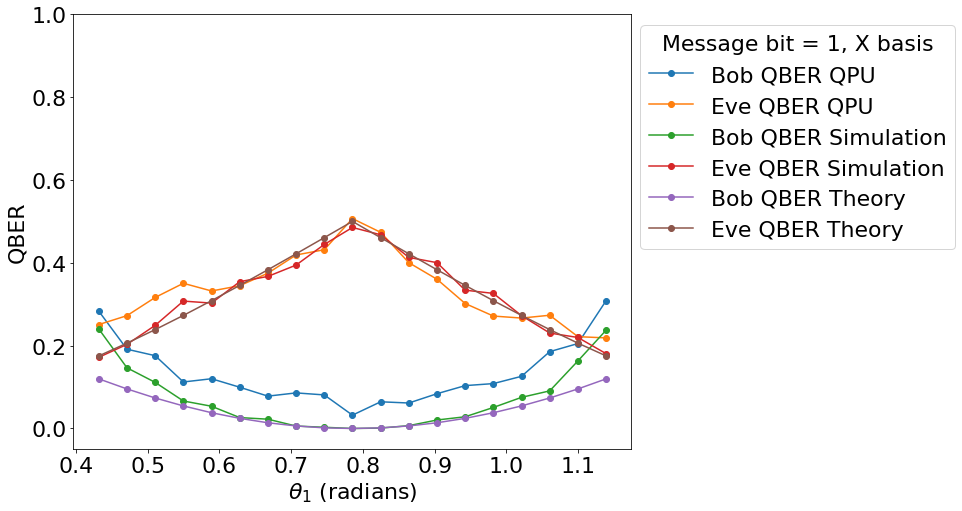

In [23]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bob_list,"-o",label="Bob QBER QPU")
plt.plot(theta1s,err_alice_list,"-o",label="Eve QBER QPU")

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER Simulation")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER Simulation")


plt.plot(theta1s,errbob_theory,"-o",label="Bob QBER Theory")
plt.plot(theta1s,erralice_theory,"-o",label="Eve QBER Theory")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 1, X basis",bbox_to_anchor=(1.6,1))
plt.show()